In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=3

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=3


In [3]:
import os
import numpy as np

import pandas as pd
import cudf as gd

from cuml.manifold.umap import UMAP as cumlUMAP

In [4]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.autonotebook import tqdm

In [6]:
DATASET_ID = 'mouse_usv_long'

In [7]:
window_length_ms = 20
hop_length_ms = 1
window_length_frames = int(window_length_ms / hop_length_ms)
window_length_frames

20

### load data

In [8]:
windows_loc = DATA_DIR/'umap_windows' / DATASET_ID / ('windows_' + str(window_length_ms)+'.npy')
windows  = np.load(windows_loc.as_posix())
np.shape(windows)

(204615, 640)

In [9]:
spec_loc = DATA_DIR/'umap_windows' / DATASET_ID / ('spec.npy')
spec_large  = np.load(spec_loc.as_posix())
np.shape(spec_large)

(820, 204634)

In [10]:
spec_loc = DATA_DIR/'umap_windows' / DATASET_ID / ('spec_small.npy')
spec  = np.load(spec_loc.as_posix())
np.shape(spec)

(32, 204634)

In [11]:
onsets_loc = DATA_DIR/'umap_windows' / DATASET_ID / ('onsets_offsets.npy')
onsets, offsets  = np.load(onsets_loc.as_posix())
np.shape(onsets), np.shape(offsets)

((1590,), (1590,))

In [12]:
excess = (np.shape(spec)[1] - len(windows))
excess

19

In [13]:
#spec = spec[:, (int(np.ceil(excess/2))):-int(np.floor(excess/2))]
spec = spec[:, :-int(excess)]

In [14]:
np.shape(spec)

(32, 204615)

### plot spec

In [15]:
rate = 250000

In [16]:
from vocalseg.utils import butter_bandpass_filter, spectrogram, int16tofloat32, plot_spec

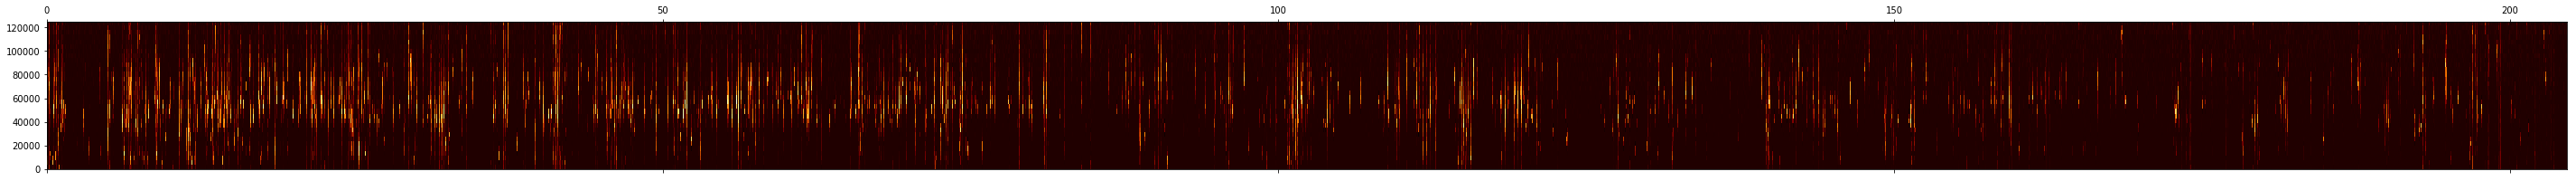

In [17]:
fig, ax = plt.subplots(figsize=(50,3))
plot_spec(spec, fig, ax, rate = rate, hop_len_ms= hop_length_ms, show_cbar=False);
plt.show()

In [18]:
from avgn.visualization.spectrogram import draw_spec_set

In [19]:
segs = [
    spec[:, int(onset * 1000 / hop_length_ms) : int(offset * 1000 / hop_length_ms)]
    for oi, (onset, offset) in tqdm(enumerate(zip(onsets, offsets)))
]
#segs = [norm(i) for i in segs if np.prod(np.shape(i)) > 0]

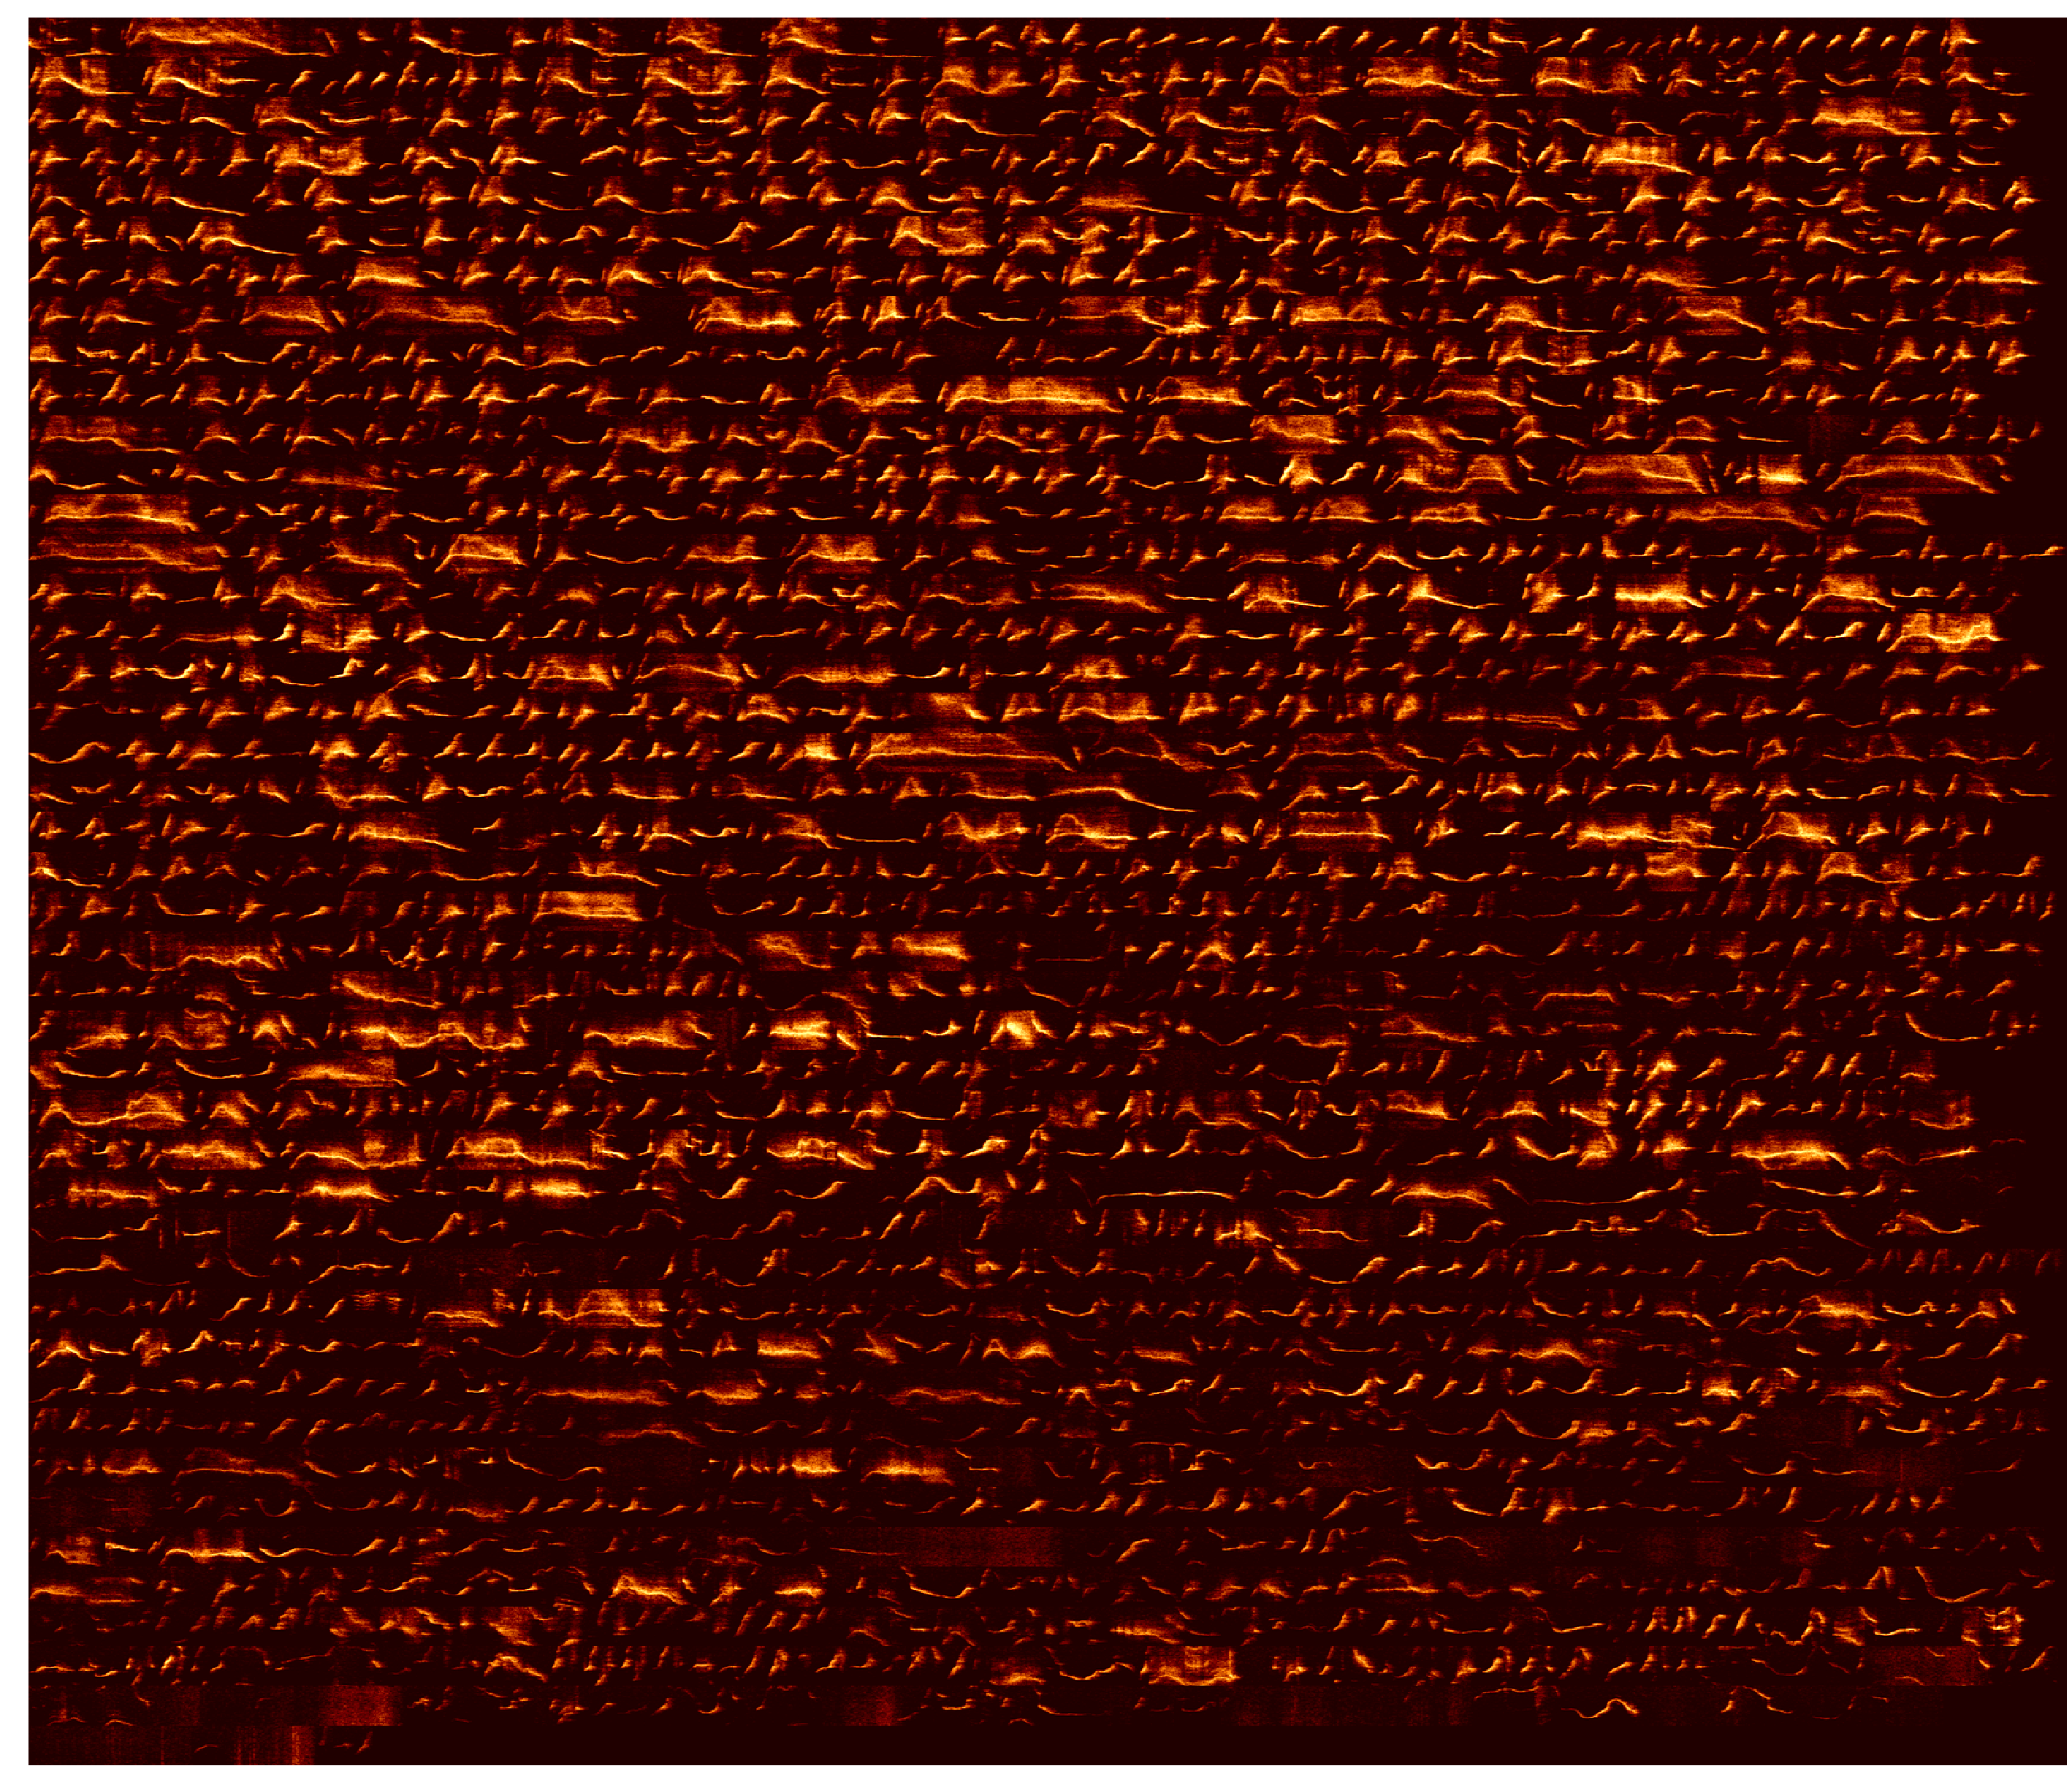

In [20]:
draw_spec_set(segs, zoom=1, maxrows=60, colsize=50)

### create embedding

In [21]:
cuml_umap = cumlUMAP(min_dist = 0.5)
embedding = cuml_umap.fit_transform(windows)

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  """Entry point for launching an IPython kernel.
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  


In [22]:
np.shape(embedding), np.min(embedding, axis=0), np.max(embedding, axis=0)

((204615, 2),
 array([-190.15371704, -201.30905151]),
 array([1234.27807617,  523.12957764]))

(-10, 10)

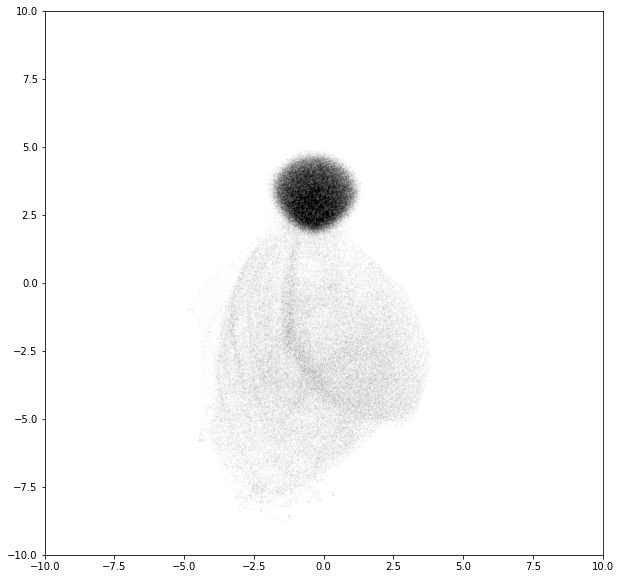

In [23]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(embedding[:,0], embedding[:,1], alpha = 0.01, s = 1, color='k')
ax.set_xlim([-10,10])
ax.set_ylim([-10,10])

In [24]:
from avgn.utils.paths import FIGURE_DIR,ensure_dir
from avgn.utils.general import save_fig

In [25]:
ensure_dir(FIGURE_DIR/'umap_seqs' / DATASET_ID)

### create power-mask for sequences

In [26]:
def norm(x):
    return (x-np.min(x))/(np.max(x)-np.min(x))

In [27]:
mask = np.expand_dims(norm(np.max(spec, axis=0)),1)
mask = (mask+1e-5)**1

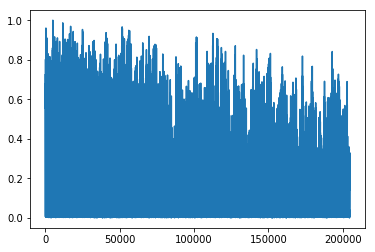

In [28]:
plt.plot(mask)

### plot seqs

In [50]:
window_z = embedding

In [54]:
xlims = [-5, 4]
ylims = [-9, 5]

In [52]:
np.shape(mask)

(204615, 1)

(-9, 5)

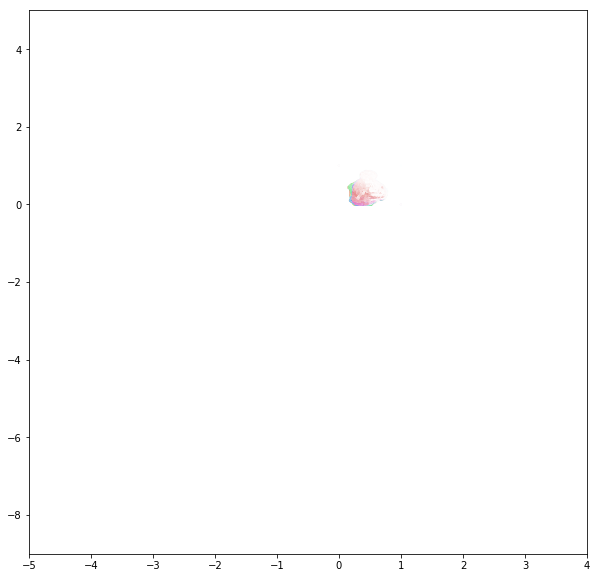

In [59]:
fig, ax = plt.subplots(figsize=(10,10))
curr_idx = 0
cols = np.array(sns.color_palette('hls', len(window_z)))
cols = 1-((1-cols) * mask) #+ (add*(mask))
ax.scatter(window_z[:,0], window_z[:,1], alpha = 1, s = 1, c= cols)
ax.set_xlim(xlims)
ax.set_ylim(ylims)
#ax.axis('off')

#save_fig(FIGURE_DIR / 'umap_seqs' / DATASET_ID / ('umap_seqs_single_'+key), save_png=True)

### plot segments individually

(-5.0, 4.0, -9.0, 5.0)

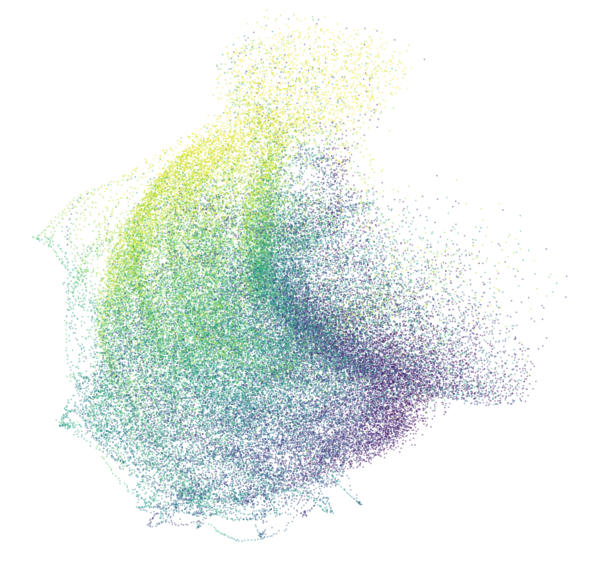

In [55]:
fig, ax = plt.subplots(figsize=(10,10))

for oi, (onset, offset) in tqdm(enumerate(zip(onsets, offsets))):
    idx_end = int(onset * 1000 / hop_length_ms)
    idx_start = int(offset * 1000 / hop_length_ms)
    seg = spec[:, idx_end:idx_start]
    window_z = embedding[idx_end:idx_start]
    cols = np.array(sns.color_palette('viridis', len(window_z)))
    ax.scatter(window_z[:,0], window_z[:,1], alpha = 0.25, s = 1, c= cols)
    #if oi == 10:
    #    break
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.axis('off')

(-5.0, 4.0, -9.0, 5.0)

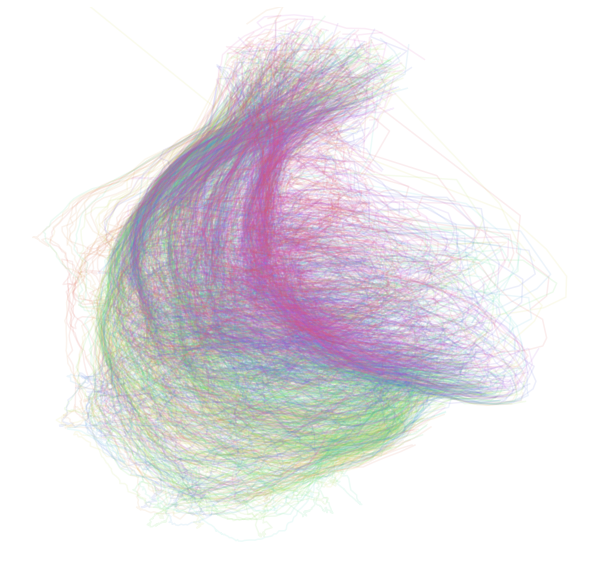

In [56]:
cols = np.array(sns.color_palette('hls', len(onsets)))
fig, ax = plt.subplots(figsize=(10,10))
for oi, (onset, offset) in tqdm(enumerate(zip(onsets, offsets))):
    idx_end = int(onset * 1000 / hop_length_ms)
    idx_start = int(offset * 1000 / hop_length_ms)
    seg = spec[:, idx_end:idx_start]
    window_z = embedding[idx_end:idx_start]
    col = cols[oi]
    ax.plot(window_z[:,0], window_z[:,1], alpha = 0.1, color= col)
    #if oi == 10:
    #    break
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.axis('off')

In [ ]:
nex = -1
scatter_spec(
    embedding[:nex],
    specs[:nex],
    column_size=15,
    x_range = xlims,
    y_range = ylims,
    pal_color="hls",
    color_points=False,
    enlarge_points=20,
    figsize=(10, 10),
    scatter_kwargs = {
        'labels': subset_df.labels.values[:nex],
        'alpha':0.05,
        's': 1,
        'show_legend': False
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':1,
        'ls':"solid",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000
);
#save_fig(FIGURE_DIR / 'phonemes', dpi=300, save_jpg=True)


In [179]:
from avgn.visualization.projections import colorline

(-5.0, 4.0, -9.0, 5.0)

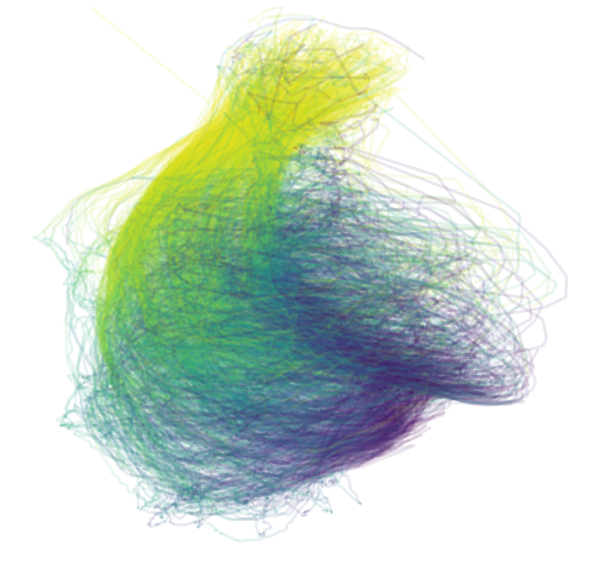

In [188]:
fig, ax = plt.subplots(figsize=(10,10))
for oi, (onset, offset) in tqdm(enumerate(zip(onsets, offsets))):
    idx_end = int(onset * 1000 / hop_length_ms)
    idx_start = int(offset * 1000 / hop_length_ms)
    seg = spec[:, idx_end:idx_start]
    window_z = embedding[idx_end:idx_start]
    colorline(window_z[:,0], window_z[:,1], alpha = 0.1, ax = ax, cmap=plt.cm.viridis)
    #if oi == 10:
    #    break
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.axis('off')

### plot specs with colorspace

In [66]:
np.shape(z_normed)

(204615, 2)

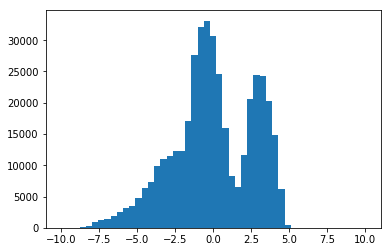

In [136]:
import copy

z_normed = copy.deepcopy(embedding)
plt.hist(z_normed.flatten(), bins = np.linspace(-10,10, 50));
z_normed[:,0][z_normed[:,0] > xlims[1]] = xlims[1]
z_normed[:,0][z_normed[:,0] < xlims[0]] = xlims[0]
z_normed[:,1][z_normed[:,1] > ylims[1]] = ylims[1]
z_normed[:,1][z_normed[:,1] < ylims[0]] = ylims[0]

z_normed[:,0] = norm(z_normed[:,0])
z_normed[:,1] = norm(z_normed[:,1])

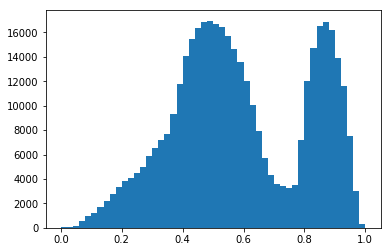

In [137]:
plt.hist(z_normed.flatten(), bins=50);

In [138]:
from matplotlib import gridspec
from vocalseg.utils import butter_bandpass_filter, spectrogram, int16tofloat32, plot_spec

In [152]:
window_z = z_normed
R = 1-norm(window_z[:,0])#*.75 + .25
G = 1-norm(window_z[:,1])#*.75 + .25
B = np.ones_like(G)*.5
RGB = np.dstack((R,G,B))
RGB = [list(i) for i in np.nan_to_num(np.squeeze(RGB))]
rgb_img = np.expand_dims(RGB,0)

In [160]:
rgb_img_masked = ((rgb_img) * mask**.25)

In [175]:
start_samp = 7000
end_samp = 8000

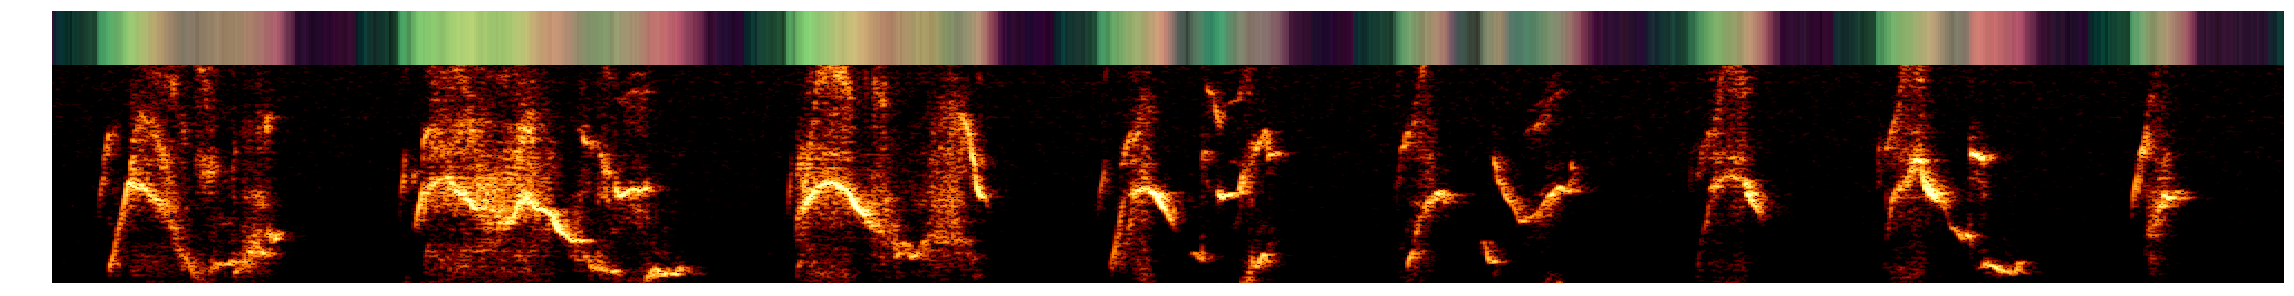

In [177]:
fig = plt.figure(figsize=(40,5)) 
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 4], wspace=0, hspace=0) 
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax0.imshow(rgb_img_masked[:,start_samp:end_samp,:], interpolation=None, aspect='auto')
#ax0.imshow(rgb_img[:,start_samp:end_samp,:], interpolation=None, aspect='auto')
plot_spec(spec_large[:,start_samp:end_samp], fig, ax1, rate = rate, hop_len_ms= hop_length_ms, show_cbar=False);
ax0.axis('off')
ax1.axis('off')
ax0.set_axis_off()
ax1.set_axis_off()

### Correlation plots